In [450]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from io import BytesIO
import glob
import random
import requests

In [451]:
# Load Teams API data
teams_json = requests.get('https://site.api.espn.com/apis/site/v2/sports/football/nfl/teams').json()
teams = teams_json['sports'][0]['leagues'][0]['teams']

team_dict = []

for t in teams:
    team_dict.append({
        'id': t['team']['id'],
        'color': t['team']['color'],
        'alternateColor': t['team']['color'],
        'logo': t['team']['logos'][0]['href'],
        'abbreviation': t['team']['abbreviation'],
        'displayName': t['team']['displayName'],
        'location': t['team']['location'],
        'name': t['team']['name'],
        'nickname': t['team']['nickname'],
        'shortDisplayName': t['team']['shortDisplayName'],
    })

# Create Teams DataFrame using team abbreviations as index
team_df = pd.DataFrame(team_dict).set_index('abbreviation')
team_df

,id,color,alternateColor,logo,displayName,location,name,nickname,shortDisplayName
abbreviation,,,,,,,,,
ARI,22,a4113e,a4113e,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png,Arizona Cardinals,Arizona,Cardinals,Cardinals,Cardinals
ATL,1,a71930,a71930,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png,Atlanta Falcons,Atlanta,Falcons,Falcons,Falcons
BAL,33,29126f,29126f,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png,Baltimore Ravens,Baltimore,Ravens,Ravens,Ravens
BUF,2,00338d,00338d,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png,Buffalo Bills,Buffalo,Bills,Bills,Bills
CAR,29,0085ca,0085ca,https://a.espncdn.com/i/teamlogos/nfl/500/car.png,Carolina Panthers,Carolina,Panthers,Panthers,Panthers
CHI,3,0b1c3a,0b1c3a,https://a.espncdn.com/i/teamlogos/nfl/500/chi.png,Chicago Bears,Chicago,Bears,Bears,Bears
CIN,4,fb4f14,fb4f14,https://a.espncdn.com/i/teamlogos/nfl/500/cin.png,Cincinnati Bengals,Cincinnati,Bengals,Bengals,Bengals
CLE,5,472a08,472a08,https://a.espncdn.com/i/teamlogos/nfl/500/cle.png,Cleveland Browns,Cleveland,Browns,Browns,Browns
DAL,6,002a5c,002a5c,https://a.espncdn.com/i/teamlogos/nfl/500/dal.png,Dallas Cowboys,Dallas,Cowboys,Cowboys,Cowboys


In [452]:
# load 2024 games DF
games_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/games.csv')))
games_df.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23


In [453]:
# plays_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-*/plays.csv')))
# Import 2024 Plays DF
plays_df = pd.read_csv('data/nfl-big-data-bowl-2024/plays.csv')
plays_df.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN


In [454]:
plays_df.dtypes

gameId                                int64
playId                                int64
ballCarrierId                         int64
ballCarrierDisplayName               object
playDescription                      object
quarter                               int64
down                                  int64
yardsToGo                             int64
possessionTeam                       object
defensiveTeam                        object
yardlineSide                         object
yardlineNumber                        int64
gameClock                            object
preSnapHomeScore                      int64
preSnapVisitorScore                   int64
passResult                           object
passLength                          float64
penaltyYards                        float64
prePenaltyPlayResult                  int64
playResult                            int64
playNullifiedByPenalty               object
absoluteYardlineNumber                int64
offenseFormation                

In [455]:
# Concatenate GameId and PlayID to create a unique ID for plays across games
# The dataset re-uses playid values across games
plays_df['play_uuid'] = plays_df['gameId'].astype(str) + '.' + plays_df['playId'].astype(str)
plays_df['play_uuid'].head()

0    2022100908.3537
1    2022091103.3126
2    2022091111.1148
3    2022100212.2007
4    2022091900.1372
Name: play_uuid, dtype: object

In [456]:
# (GITHUB COLAB AI) 
# prompt: load all CSV files with a name like "tracking_week_" into a tracking_df dataframe
import glob
tracking_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/*week*.csv')))

In [457]:
# generate same Play-UUID for frame lookup
tracking_df['play_uuid'] = tracking_df['gameId'].astype(str) + '.' + tracking_df['playId'].astype(str)
tracking_df['play_uuid'].head()

0    2022100600.90
1    2022100600.90
2    2022100600.90
3    2022100600.90
4    2022100600.90
Name: play_uuid, dtype: object

In [458]:
# List event types from Tracking table
tracking_df['event'].unique()

array([nan, 'ball_snap', 'handoff', 'first_contact', 'tackle',
       'pass_arrived', 'pass_outcome_caught', 'out_of_bounds', 'run',
       'fumble', 'man_in_motion', 'autoevent_passforward', 'shift',
       'play_action', 'touchdown', 'pass_forward', 'snap_direct',
       'line_set', 'qb_slide', 'autoevent_ballsnap',
       'autoevent_passinterrupted', 'pass_shovel', 'lateral',
       'penalty_flag', 'qb_sack', 'fumble_offense_recovered', 'safety',
       'pass_outcome_touchdown', 'fumble_defense_recovered',
       'run_pass_option', 'penalty_accepted'], dtype=object)

In [459]:
# Filter tracking_df for the Ball Snap Frames
ball_snap_df = tracking_df.loc[(tracking_df['event'] == 'ball_snap')]
ball_snap_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [460]:
# Filter for plays where we have all 22 Player positions in the snap frame
position_counts = ball_snap_df[['play_uuid', 'nflId']].groupby('play_uuid').count()
all_22_play_ids = position_counts.loc[(position_counts['nflId'] == 22)].index
all_22_play_ids

Index(['2022090800.101', '2022090800.1187', '2022090800.1254',
       '2022090800.1385', '2022090800.1406', '2022090800.146',
       '2022090800.1736', '2022090800.191', '2022090800.1946',
       '2022090800.2043',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=6323)

In [461]:
# Create a DF of the plays with all-22 Frames available
all_22_plays_df = plays_df.loc[(plays_df['play_uuid'].isin(all_22_play_ids))]
all_22_plays_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,play_uuid
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN,2022091103.3126
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN,2022100212.2007
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN,2022091900.1372
7,2022102310,56,46377,Jeffery Wilson,(15:00) J.Wilson left tackle to SF 32 for 7 ya...,1,1,10,SF,KC,...,0.431279,0.001382,-0.001382,1.298699,0.282340,NaN,NaN,NaN,NaN,2022102310.56
8,2022102310,1318,41325,Jerick McKinnon,(10:31) (Shotgun) J.McKinnon left guard to KC ...,2,1,10,KC,SF,...,0.320394,-0.015303,0.015303,1.827773,0.733410,NaN,NaN,NaN,NaN,2022102310.1318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12477,2022102307,1224,42358,Melvin Gordon,(14:18) (Shotgun) M.Gordon left tackle to NYJ ...,2,2,8,DEN,NYJ,...,0.541196,-0.036002,0.036002,1.939443,-0.817222,NaN,NaN,NaN,NaN,2022102307.1224
12481,2022100204,123,43293,Ezekiel Elliott,(13:31) E.Elliott right tackle to WAS 38 for 1...,1,1,10,DAL,WAS,...,0.361400,-0.011542,0.011542,3.642571,-0.504018,NaN,NaN,NaN,NaN,2022100204.123
12483,2022101605,3371,44860,Joe Mixon,(9:35) (Shotgun) J.Mixon left end to CIN 47 fo...,4,1,10,CIN,NO,...,0.332946,-0.005164,0.005164,2.115356,0.203819,NaN,NaN,NaN,NaN,2022101605.3371
12484,2022100207,2777,52449,Jonathan Taylor,(2:02) (Shotgun) J.Taylor up the middle to TEN...,3,1,10,IND,TEN,...,0.589389,-0.046648,0.046648,3.946232,-0.976039,NaN,NaN,NaN,NaN,2022100207.2777


In [462]:
# Filter for 3rd down plays from the all-22 plays DF
third_down_df = all_22_plays_df.loc[(all_22_plays_df['down'] == 3)]
third_down_df.columns

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'play_uuid'],
      dtype='object')

In [463]:
# filter for tracking frames from the all-22 df and the ball snap event.
# These will all be 22 players and the ball for each play_uuid
all_22_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(all_22_play_ids))]
all_22_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [464]:
# create a DF of player positions for all-22 3rd down snaps
third_down_frames_df = all_22_frames_df.loc[(all_22_frames_df['play_uuid'].isin(third_down_df['play_uuid']))]
third_down_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
22683,2022100600,1069,38540.0,Stephon Gilmore,6,2022-10-06 20:58:22.400000,5.0,IND,left,38.44,14.13,0.05,0.05,0.00,37.15,272.30,ball_snap,2022100600.1069
22734,2022100600,1069,38605.0,Russell Wilson,6,2022-10-06 20:58:22.400000,3.0,DEN,left,45.20,23.77,0.00,0.00,0.01,272.11,354.59,ball_snap,2022100600.1069
22785,2022100600,1069,38843.0,Rodney McLeod,6,2022-10-06 20:58:22.400000,26.0,IND,left,40.60,18.62,0.01,0.01,0.00,76.12,96.10,ball_snap,2022100600.1069
22836,2022100600,1069,41369.0,Cameron Fleming,6,2022-10-06 20:58:22.400000,73.0,DEN,left,45.05,26.58,0.56,1.91,0.06,273.86,214.51,ball_snap,2022100600.1069
22887,2022100600,1069,42358.0,Melvin Gordon,6,2022-10-06 20:58:22.400000,25.0,DEN,left,49.91,23.79,0.11,0.63,0.01,261.38,256.08,ball_snap,2022100600.1069


In [465]:
third_down_frames_df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event', 'play_uuid'],
      dtype='object')

In [466]:
# Select a random play from the all-22 plays
random_play =  random.randint(0, len(all_22_plays_df))
random_id = all_22_plays_df.iloc[random_play]['play_uuid']
# Select the tracking player positions from ball-snap for this play
play_frame = all_22_frames_df.loc[(all_22_frames_df['play_uuid'] == random_id)]
play_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
76549,2022092900,3198,38548.0,Melvin Ingram,6,2022-09-29 22:52:26.400000,6.0,MIA,left,45.160000,17.110000,0.10,0.70,0.02,57.43,57.36,ball_snap,2022092900.3198
76620,2022092900,3198,40030.0,John Jenkins,6,2022-09-29 22:52:26.400000,77.0,MIA,left,44.860000,23.710000,0.02,0.32,0.00,79.84,7.57,ball_snap,2022092900.3198
76691,2022092900,3198,42654.0,La'el Collins,6,2022-09-29 22:52:26.400000,71.0,CIN,left,47.190000,26.990000,0.13,0.70,0.02,268.05,302.87,ball_snap,2022092900.3198
76762,2022092900,3198,43510.0,Ted Karras,6,2022-09-29 22:52:26.400000,64.0,CIN,left,46.340000,23.810000,0.06,0.65,0.01,243.86,335.50,ball_snap,2022092900.3198
76833,2022092900,3198,44860.0,Joe Mixon,6,2022-09-29 22:52:26.400000,28.0,CIN,left,53.170000,23.730000,0.00,0.00,0.00,256.33,258.22,ball_snap,2022092900.3198
76904,2022092900,3198,44887.0,Duke Riley,6,2022-09-29 22:52:26.400000,45.0,MIA,left,41.080000,23.450000,0.40,1.10,0.04,84.55,86.36,ball_snap,2022092900.3198
76975,2022092900,3198,46142.0,Jerome Baker,6,2022-09-29 22:52:26.400000,55.0,MIA,left,41.770000,27.010000,0.14,0.08,0.06,74.87,91.63,ball_snap,2022092900.3198
77046,2022092900,3198,46163.0,Alex Cappa,6,2022-09-29 22:52:26.400000,65.0,CIN,left,47.070000,25.510000,0.16,0.77,0.02,270.79,1.91,ball_snap,2022092900.3198
77117,2022092900,3198,46307.0,Zach Sieler,6,2022-09-29 22:52:26.400000,92.0,MIA,left,44.880000,21.230000,0.01,0.23,0.00,68.91,56.87,ball_snap,2022092900.3198
77188,2022092900,3198,46312.0,Keion Crossen,6,2022-09-29 22:52:26.400000,27.0,MIA,left,44.110000,9.490000,0.01,0.01,0.02,80.77,251.13,ball_snap,2022092900.3198


In [467]:
# Select the play record
play = all_22_plays_df.loc[(all_22_plays_df['play_uuid'] == random_id)].iloc[0]
play

gameId                                                                     2022092900
playId                                                                           3198
ballCarrierId                                                                   44860
ballCarrierDisplayName                                                      Joe Mixon
playDescription                     (7:11) H.Adeniji reported in as eligible.  J.M...
quarter                                                                             4
down                                                                                1
yardsToGo                                                                          10
possessionTeam                                                                    CIN
defensiveTeam                                                                     MIA
yardlineSide                                                                      MIA
yardlineNumber                                        

In [468]:
# Select the game for this play
game = games_df.loc[(games_df['gameId'] == play['gameId'])].iloc[0]
game

gameId               2022092900
season                     2022
week                          4
gameDate             09/29/2022
gameTimeEastern        20:15:00
homeTeamAbbr                CIN
visitorTeamAbbr             MIA
homeFinalScore               27
visitorFinalScore            15
Name: 48, dtype: object

In [469]:
# Load the Home team logo from the ESPN API 
response = requests.get(team_df.loc[game['homeTeamAbbr']]['logo'])
home_img = Image.open(BytesIO(response.content))
# Load the away team logo from the ESPN API
response = requests.get(team_df.loc[game['visitorTeamAbbr']]['logo'])
away_img = Image.open(BytesIO(response.content))

In [470]:
# Initialize team colors from the ESPN API
teams = play_frame['club'].unique()
colors = {teams[0]: mcolors.to_rgba('#' + team_df.loc[teams[0]]['color']), 
          teams[1]: mcolors.to_rgba('#' + team_df.loc[teams[1]]['color']), 
          'football': 'brown'}
alt_colors = {teams[0]: mcolors.to_rgba('#' + team_df.loc[teams[0]]['alternateColor']), 
          teams[1]: mcolors.to_rgba('#' + team_df.loc[teams[1]]['alternateColor']), 
          'football': 'yellow'}

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_65573/4240212250.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']


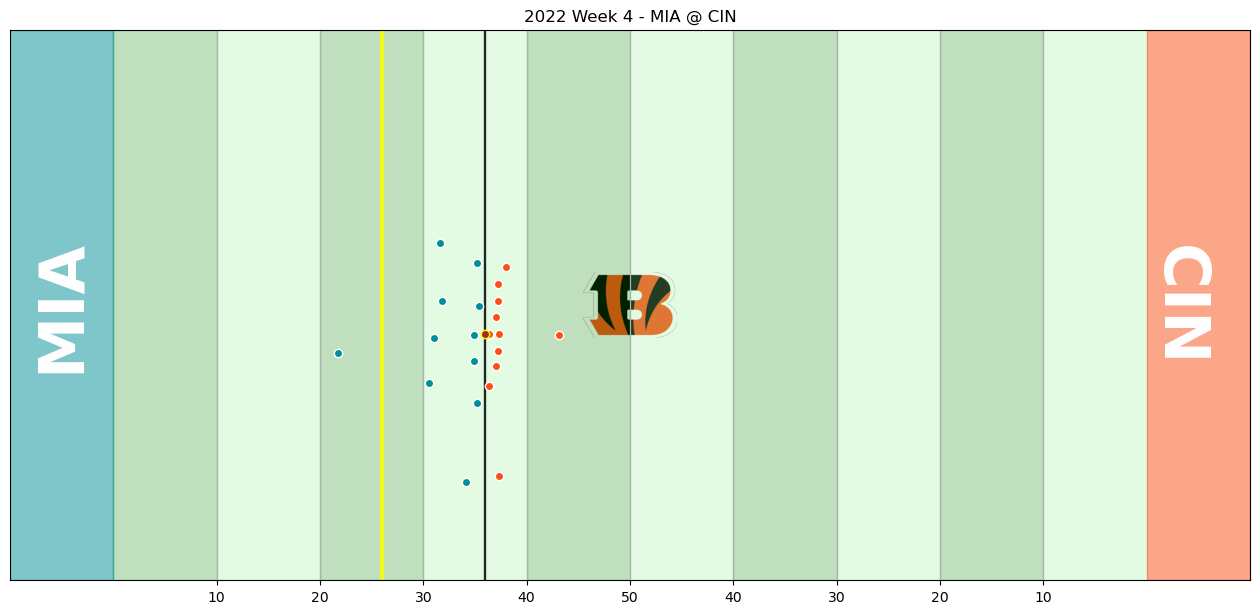

In [471]:
# Build Field and Play formation plot with Matplotlib

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113, 26.65], xytext=[113, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()
